In [48]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [49]:

#reading data
df=pd.read_excel("Tenders__.xlsx")
df.head()

,Tender Type,Regions,Conditionsbookletprice,Tender Status,Invitation Type,Submitiondate,Lastofferpresentationdate,Activity Name,Estimatedvalue,Invit Count,categories_count,regions_count,latest_awarding_date
0,Direct purchase,city11,0.0,completed,private,2019-12-18 13:51:58.332,2019-12-23 00:00:00,"Trade of tools, machines and devices",19444.444444,7,2,1,2020-02-13 13:18:27
1,Direct purchase,city11,0.0,completed,private,2019-12-18 13:51:58.332,2019-12-23 00:00:00,information technology,19444.444444,7,2,1,2020-02-13 13:18:27
2,Direct purchase,city11,0.0,completed,private,2019-12-22 12:53:07.624,2019-12-31 00:00:00,Insurance Activities,32777.777778,7,1,1,2020-02-13 13:12:54
3,Limited tender,city11,0.0,completed,private,2019-12-23 19:37:15.997,2019-12-26 00:00:00,"Trade of tools, machines and devices",179444.444444,5,3,1,2020-02-20 17:47:36
4,Limited tender,city11,0.0,completed,private,2019-12-23 19:37:15.997,2019-12-26 00:00:00,Trading of utensils and household appliances,179444.444444,5,3,1,2020-02-20 17:47:36


In [50]:
df["Regions"]=df["Regions"].fillna("No Region")
#fill nulls with 0s
df["Conditionsbookletprice"]=df["Conditionsbookletprice"].fillna(0)
#fill nulls with No Invite'
df["Invitation Type"]=df["Invitation Type"].fillna("No Invite")
#fill nulls with 0s
df["Estimatedvalue"]=df["Estimatedvalue"].fillna(0)
#drop nulls
df.dropna(subset=["Activity Name"],inplace=True)
#replace spaces 
df["Regions"]=df["Regions"].str.replace(' ','')
df["Regions"].unique()
#crete new columns form rows
Regions=['city11','city10','city9','city8','city7','city6','city5','city4','city3','city2','city12','city13','city1']
for r in Regions:
    df[r]=df["Regions"].str.contains(r)
    
df.drop(inplace=True,axis=1,columns=["Regions"])
#df.drop(axis=1,columns=["Submitiondate","Lastofferpresentationdate","Activity Name","latest_awarding_date"], inplace=True)
df.drop(axis=1,columns=["Submitiondate","Lastofferpresentationdate","latest_awarding_date"], inplace=True)

df=pd.get_dummies(df,columns=["Invitation Type"], prefix='Invitation_Type',drop_first=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 160384 entries, 0 to 160731
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Tender Type              160384 non-null  object 
 1   Conditionsbookletprice   160384 non-null  float64
 2   Tender Status            160384 non-null  object 
 3   Activity Name            160384 non-null  object 
 4   Estimatedvalue           160384 non-null  float64
 5   Invit Count              160384 non-null  int64  
 6   categories_count         160384 non-null  int64  
 7   regions_count            160384 non-null  int64  
 8   city11                   160384 non-null  bool   
 9   city10                   160384 non-null  bool   
 10  city9                    160384 non-null  bool   
 11  city8                    160384 non-null  bool   
 12  city7                    160384 non-null  bool   
 13  city6                    160384 non-null  bool   
 14  city

In [51]:
def get_invitations_group_status(inv_count):
    if inv_count==0:
        return "no_invitations"
    elif inv_count>0 and inv_count<50:
        return "invitations_less_50"
    elif inv_count>50 and inv_count<100:
        return "invitations_bet_50_100"
    elif inv_count>100 and inv_count<150:
        return "invitations_bet_100_150"
    elif inv_count>150 and inv_count<200:
         return "invitations_bet_150_200"
    else:
        return "invitations_more_200"
    
df["invitations_group"]=df["Invit Count"].apply(get_invitations_group_status)

def get_Conditionsbookletprice_group_status(price):
    if price==0:
        return "no_bookletprice"
    elif price>0 and price<100:
        return "bookletprice_less_100"
    elif price>100 and price<100000:
        return "bookletprice_bet_100_100k"
    else:
        return "bookletprice_more_100k"
df["booklet_price_group"]=df["Conditionsbookletprice"].apply(get_Conditionsbookletprice_group_status)

def get_Estimatedvalue_status(Estimatedvalue):
    if Estimatedvalue==0:
        return "no_Estimatedvalue"
    elif Estimatedvalue<100000:
        return "Estimatedvalue_less_100k"
    elif Estimatedvalue>100000 and Estimatedvalue<1000000:
        return "Estimatedvalue_bet_100k_1m"
    elif Estimatedvalue>1000000 and Estimatedvalue<10000000:
        return "Estimatedvalue_bet_1m_10m"
    else:
        return "Estimatedvalue_more_10m"
df["Estimatedvalue_group"]=df["Estimatedvalue"].apply(get_Estimatedvalue_status)

In [52]:
df.drop(columns=["Estimatedvalue","Invit Count","Conditionsbookletprice"],inplace=True)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160384 entries, 0 to 160731
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Tender Type              160384 non-null  object
 1   Tender Status            160384 non-null  object
 2   Activity Name            160384 non-null  object
 3   categories_count         160384 non-null  int64 
 4   regions_count            160384 non-null  int64 
 5   city11                   160384 non-null  bool  
 6   city10                   160384 non-null  bool  
 7   city9                    160384 non-null  bool  
 8   city8                    160384 non-null  bool  
 9   city7                    160384 non-null  bool  
 10  city6                    160384 non-null  bool  
 11  city5                    160384 non-null  bool  
 12  city4                    160384 non-null  bool  
 13  city3                    160384 non-null  bool  
 14  city2               

In [54]:
df2=df
df=pd.get_dummies(df,columns=["Activity Name"], prefix='Activity_Name_')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160384 entries, 0 to 160731
Columns: 124 entries, Tender Type to Activity_Name__wear making
dtypes: bool(13), int64(2), object(5), uint8(104)
memory usage: 27.7+ MB


In [55]:
#df.drop(axis=1,inplace=True,columns=["Activity Name"])

In [56]:
def convert_status(text):
    if text=="completed":
        return 0
    else:
        return 1
df["Status"]=0
df["Status"]=df["Tender Status"].apply(convert_status)
df["Status"].value_counts()

0    103364
1     57020
Name: Status, dtype: int64

In [57]:
df.drop(axis=1,inplace=True,columns=["Tender Status"])
df=pd.get_dummies(df,columns=["Tender Type"], prefix='Tender_Type',drop_first=True)

In [58]:
df=pd.get_dummies(df,columns=["Estimatedvalue_group","booklet_price_group","invitations_group"])

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
X=df.loc[:, df.columns != 'Status']
y=df["Status"]
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1000)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3000)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_val = scaler.transform(X_val.values)
X_test = scaler.transform(X_test.values)
lg = LogisticRegression().fit(X_train, y_train)
y_pred_val=lg.predict(X_val)
print('Linear Regression score:',lg.score(X_val, y_val))
print('Linear Regression recall:\n',metrics.classification_report( y_val,y_pred_val))

Linear Regression score: 0.7188156910250472
Linear Regression recall:
               precision    recall  f1-score   support

           0       0.71      0.96      0.81     17984
           1       0.80      0.29      0.43     10083

    accuracy                           0.72     28067
   macro avg       0.75      0.62      0.62     28067
weighted avg       0.74      0.72      0.67     28067



In [29]:
df["Status"].mean()

0.35552174780526735

In [60]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)
lg=LogisticRegression()
dt= DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
xgbc = xgb.XGBClassifier()
rm=RandomForestClassifier()
print("LogisticRegression F1 Mean:",np.mean(cross_val_score(lg, X, y, cv=kf, scoring='f1_macro')))
print("DecisionTree F1 Mean:",np.mean(cross_val_score(dt, X, y, cv=kf, scoring='f1_macro')))
print("KNeighborsClassifier F1 Mean:",np.mean(cross_val_score(knn, X, y, cv=kf, scoring='f1_macro')))
print("XGBClassifier F1 Mean:",np.mean(cross_val_score(xgbc, X, y, cv=kf, scoring='f1_macro')))
#print("RandomForestClassifier Recall Mean:",np.mean(cross_val_score(rm, X, y, cv=kf, scoring='f1_macro')))

print("LogisticRegression Precision Mean:",np.mean(cross_val_score(lg, X, y, cv=kf, scoring='precision_macro')))
print("DecisionTree Precision Mean:",np.mean(cross_val_score(dt, X, y, cv=kf, scoring='precision_macro')))
print("KNeighborsClassifier Precision Mean:",np.mean(cross_val_score(knn, X, y, cv=kf, scoring='precision_macro')))
print("XGBClassifier Precision Mean:",np.mean(cross_val_score(xgbc, X, y, cv=kf, scoring='precision_macro')))
#print("RandomForestClassifier Recall Mean:",np.mean(cross_val_score(rm, X, y, cv=kf, scoring='precision_macro')))

print("LogisticRegression Recall Mean:",np.mean(cross_val_score(lg, X, y, cv=kf, scoring='recall_macro')))
print("DecisionTree Recall Mean:",np.mean(cross_val_score(dt, X, y, cv=kf, scoring='recall_macro')))
print("KNeighborsClassifier Recall Mean:",np.mean(cross_val_score(knn, X, y, cv=kf, scoring='recall_macro')))
print("XGBClassifier Recall Mean:",np.mean(cross_val_score(xgbc, X, y, cv=kf, scoring='recall_macro')))
#print("RandomForestClassifier Recall Mean:",np.mean(cross_val_score(rm, X, y, cv=kf, scoring='recall_macro')))

LogisticRegression F1 Mean: 0.6224009616511178
DecisionTree F1v Mean: 0.6639798352087027
KNeighborsClassifier F1 Mean: 0.6481574351031657
[18:02:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:02:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Ex

In [61]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

dt = DecisionTreeClassifier()
random_grid={
    #'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt', 'log2',None],
 'min_samples_leaf': [1, 2, 4],
    'criterion' :['gini', 'entropy'],
 'min_samples_split': [2, 5, 10]#,
 #'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
            }
CV__Randdt = RandomizedSearchCV(estimator=dt, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1,scoring="recall_macro")
CV__Randdt.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='recall_macro', verbose=2)

In [70]:
y_pred_val=CV__Randdt.predict(X_val)
print("DecisionTree Score in validation \n",metrics.classification_report(y_val, y_pred_val))
y_pred_test=CV__Randdt.predict(X_test)
print("DecisionTree Score in test \n",metrics.classification_report(y_test, y_pred_test))

DecisionTree Score in validation 
               precision    recall  f1-score   support

           0       0.73      0.92      0.81     17984
           1       0.74      0.40      0.51     10083

    accuracy                           0.73     28067
   macro avg       0.73      0.66      0.66     28067
weighted avg       0.73      0.73      0.71     28067

DecisionTree Score in test 
               precision    recall  f1-score   support

           0       0.73      0.92      0.81     31005
           1       0.72      0.39      0.50     17111

    accuracy                           0.73     48116
   macro avg       0.73      0.65      0.66     48116
weighted avg       0.73      0.73      0.70     48116



In [63]:
CV__Randdt.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 90,
 'criterion': 'entropy'}

In [65]:
dt=DecisionTreeClassifier(criterion='entropy',
 max_depth= 90,
 max_features=None,
 min_samples_leaf=1,
 min_samples_split= 2)
dt.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=90)

In [39]:
np.array(df.columns)[0:20]

array(['categories_count', 'regions_count', 'city11', 'city10', 'city9',
       'city8', 'city7', 'city6', 'city5', 'city4', 'city3', 'city2',
       'city12', 'city13', 'city1', 'Invitation_Type_private',
       'Invitation_Type_public',
       'Activity_Name__ Manufacture of machinery and equipment not elsewhere classified',
       'Activity_Name__ Trading of home furniture, furnishings, curtains and carpets',
       'Activity_Name__Agricultural Trade'], dtype=object)

In [66]:
df_fetures_importance=pd.DataFrame(fetures_importance)
df_fetures_importance.sort_values(by=["score"],ascending=False)

,name,score
131,Estimatedvalue_group_no_Estimatedvalue,0.301019
139,invitations_group_invitations_less_50,0.077039
0,categories_count,0.069769
120,Tender_Type_General tender,0.056894
141,invitations_group_no_invitations,0.028263
...,...,...
123,Tender_Type_Post qualification,0.000000
114,Activity_Name__the hunt,0.000000
93,Activity_Name__customs clearance services,0.000000
26,Activity_Name__Coal and firewood trade,0.000000


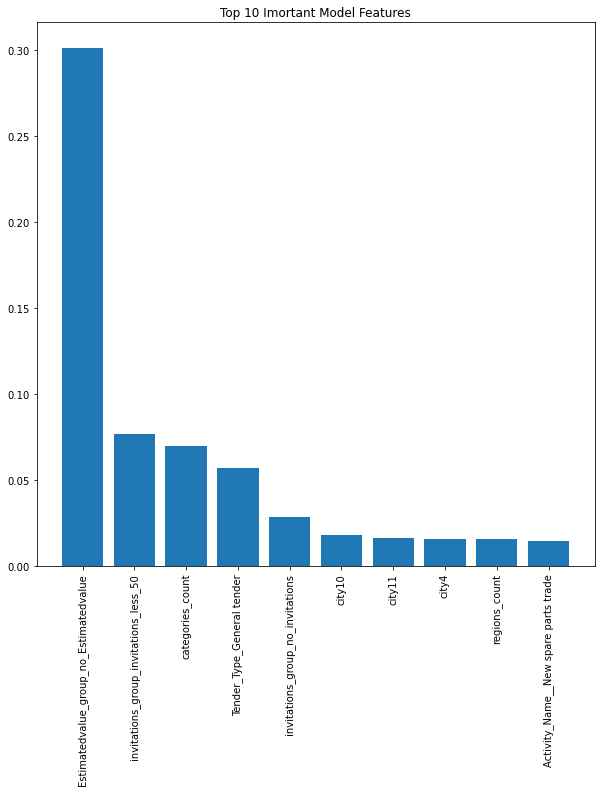

<Figure size 432x288 with 0 Axes>

In [68]:
top10=df_fetures_importance.nlargest(10, 'score')
plt.figure(figsize=(10, 10))
plt.bar(top10["name"], top10["score"])
plt.xticks(rotation=90)
plt.title("Top 10 Imortant Model Features")
plt.show()
plt.savefig('Top 10 Imortant Model Features.png')